# Title

# Description

# Importation

In [1]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
import pandas as pd

files = [
    "holidays.csv",
    "dates.csv",
    "SampleSubmission.csv",
    "stores.csv",
    "test.csv",
    "train.csv"
]

base_url = "https://raw.githubusercontent.com/ikoghoemmanuell/Grocery-Store-Forecasting-Challenge-For-Azubian/main/assets/data/"

data = {}

for file in files:
    url = base_url + file
    # if file == "train.csv":
    #     data[file] = pd.read_csv(url, parse_dates=["date"])
    # else:
    data[file] = pd.read_csv(url)

# Access the data using dictionary keys
holidays = data["holidays.csv"]
dates = data["dates.csv"]
sample = data["SampleSubmission.csv"]
stores = data["stores.csv"]
test = data["test.csv"]
train = data["train.csv"]

# Dataset overview

In [4]:
train.head()

,date,store_id,category_id,target,onpromotion,nbr_of_transactions
0,365,store_1,category_24,0.0,0,0.0
1,365,store_1,category_21,0.0,0,0.0
2,365,store_1,category_32,0.0,0,0.0
3,365,store_1,category_18,0.0,0,0.0
4,365,store_1,category_26,0.0,0,0.0


the target column to sales, so change it

In [5]:
# renaming target column in train
train.rename(columns={'target': 'sales'}, inplace=True)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248884 entries, 0 to 2248883
Data columns (total 6 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 int64  
 1   store_id             object 
 2   category_id          object 
 3   sales                float64
 4   onpromotion          int64  
 5   nbr_of_transactions  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 102.9+ MB


train date is in numerical format. We'll have to convert it to Datetime format later

In [7]:
test.head()

,date,store_id,category_id,onpromotion
0,1627,store_1,category_24,0
1,1627,store_1,category_21,0
2,1627,store_1,category_32,0
3,1627,store_1,category_18,16
4,1627,store_1,category_26,0


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99792 entries, 0 to 99791
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         99792 non-null  int64 
 1   store_id     99792 non-null  object
 2   category_id  99792 non-null  object
 3   onpromotion  99792 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.0+ MB


In [9]:
stores.head()

,store_id,city,type,cluster
0,store_1,0,0,0
1,store_2,0,0,0
2,store_3,0,0,1
3,store_4,0,0,2
4,store_5,1,0,3


In [10]:
stores.city.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [11]:
stores.type.unique()

array([0, 1, 2, 3, 4])

In [12]:
stores.cluster.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [13]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   store_id  54 non-null     object
 1   city      54 non-null     int64 
 2   type      54 non-null     int64 
 3   cluster   54 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.8+ KB


city, type & cluster are categoric variables, so they are not supposed to be in number datatype(int64) 

furthermore, cities do not have an ordinal relationship with one another. Ordinal variables have a natural order. Just like "good-better-best" or "positive-neutral-negative". Nominal variables don't.

We don't want our machine learning models to think that one city-0 comes before city-1, which is before city-3. 

Therefore, we'll have to change the datatypes to obect or string to make it more descriptive, for example: 'London', 'Tokyo', 'Rome' and so on.

Same goes for type and cluster.

In [14]:
dates.head()

,date,year,month,dayofmonth,dayofweek,dayofyear,weekofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,year_weekofyear
0,365,1,1,1,2,1,1,1,True,False,True,False,True,False,101
1,366,1,1,2,3,2,1,1,False,False,False,False,False,False,101
2,367,1,1,3,4,3,1,1,False,False,False,False,False,False,101
3,368,1,1,4,5,4,1,1,False,False,False,False,False,False,101
4,369,1,1,5,6,5,1,1,False,False,False,False,False,False,101


This dataset contains dates and the features that have already been extracted from it

In [15]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   date              1320 non-null   int64
 1   year              1320 non-null   int64
 2   month             1320 non-null   int64
 3   dayofmonth        1320 non-null   int64
 4   dayofweek         1320 non-null   int64
 5   dayofyear         1320 non-null   int64
 6   weekofyear        1320 non-null   int64
 7   quarter           1320 non-null   int64
 8   is_month_start    1320 non-null   bool 
 9   is_month_end      1320 non-null   bool 
 10  is_quarter_start  1320 non-null   bool 
 11  is_quarter_end    1320 non-null   bool 
 12  is_year_start     1320 non-null   bool 
 13  is_year_end       1320 non-null   bool 
 14  year_weekofyear   1320 non-null   int64
dtypes: bool(6), int64(9)
memory usage: 100.7 KB


in this case, these categories have an ordinal relationship with one another, meaning one naturally comes before the other, 

so we can leave them as they are.

In [16]:
dates.dayofweek.unique()

array([2, 3, 4, 5, 6, 0, 1])

there are 7days in a week, so this is fine.

In [17]:
dates.dayofyear.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

we have 365 days in a year, 366 days is for a loop year. This is a problem for us. Let me explain why.

**Problem**:
When you have a loop year, then new year's eve would fall on day 366

otherwise, it would fall on day 365. So everyday might not fall on the appropriate number for each year.

**Solution**:
we will later convert two new columns called "sin(dayofyear)" & "cos(dayofyear)". These new columns will help our machine learning models to understand the cyclic nature of a year. 

Cyclic means that a year usually starts and ends in a similar way.

In [18]:
holidays.head()

,date,type
0,1,0
1,5,4
2,12,4
3,42,0
4,43,0


In [19]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   date    281 non-null    int64
 1   type    281 non-null    int64
dtypes: int64(2)
memory usage: 4.5 KB


In [20]:
holidays.type.unique()

array([0, 4, 2, 5, 1, 3])

The type column is a categoric variable, and each type of holiday does not have an ordinal relationship, since a holiday like new year is not higher or better than Christmas for example.

so we'll later convert them to string type to make it more descriptive

In [21]:
train.describe()

,date,sales,onpromotion,nbr_of_transactions
count,2.248884e+06,2.248884e+06,2.248884e+06,2.248884e+06
mean,9.955000e+02,3.932649e+02,3.142002e+00,1.573591e+03
std,3.643080e+02,1.174938e+03,1.343616e+01,1.027832e+03
min,3.650000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.800000e+02,0.000000e+00,0.000000e+00,9.440000e+02
50%,9.955000e+02,1.500000e+01,0.000000e+00,1.338000e+03
75%,1.311000e+03,2.230000e+02,1.000000e+00,1.979000e+03
max,1.626000e+03,1.247170e+05,7.410000e+02,8.359000e+03


train dates range from **365** to **1626**

In [22]:
test.describe()

,date,onpromotion
count,99792.000000,99792.000000
mean,1654.500000,7.274892
std,16.163311,18.504041
min,1627.000000,0.000000
25%,1640.750000,0.000000
50%,1654.500000,0.000000
75%,1668.250000,6.000000
max,1682.000000,591.000000


test dates range from **1627** to **1682**

this is a continuation from train. This makes sense since we are to predict future transactions based on past data

**note**: we will not be using transaction data to train our models, since transaction data was not provided for our test data.

In [23]:
dates.describe(),

(              date         year        month   dayofmonth    dayofweek  \
 count  1320.000000  1320.000000  1320.000000  1320.000000  1320.000000   
 mean   1024.500000     2.344697     6.124242    15.612121     2.996970   
 std     381.195488     1.059333     3.366835     8.798020     2.001135   
 min     365.000000     1.000000     1.000000     1.000000     0.000000   
 25%     694.750000     1.000000     3.000000     8.000000     1.000000   
 50%    1024.500000     2.000000     6.000000    15.500000     3.000000   
 75%    1354.250000     3.000000     9.000000    23.000000     5.000000   
 max    1684.000000     4.000000    12.000000    31.000000     6.000000   
 
          dayofyear   weekofyear      quarter  year_weekofyear  
 count  1320.000000  1320.000000  1320.000000      1320.000000  
 mean    170.871970    24.934848     2.384091       259.101515  
 std     102.870939    14.726066     1.094568       104.162039  
 min       1.000000     1.000000     1.000000       101.000000 

dates are from **365** till **1684** which covers the train and test dates

so, we'll be able to add the features from here to both the train and test data based on the date

In [24]:
 holidays.describe()

,date,type
count,281.000000,281.000000
mean,901.896797,1.402135
std,461.359327,1.996031
min,1.000000,0.000000
25%,540.000000,0.000000
50%,934.000000,0.000000
75%,1237.000000,2.000000
max,1684.000000,5.000000


In [25]:
# count the number of dates in the holidays dataset
holidays.date.nunique()

251

notice that the dates in the holiday dataset are not complete

so, we will later create a column for holidays in our train and test dataset based on the following logic:

if a date is in the holidays table, then its a holiday, else that date is not a holiday

## Hypothesis
**H0**: holidays have a big effect on sales, hence the sales data is seasonal.

**H1**: holidays don't affect sales, hence sales data is stationary.

## Questions

1. Is the train data complete?
2. Do we have seasonality in our transactions?
3. Are there outliers in our dataset?
4. What is the difference between RMSLE, RMSE and MSE?

## Issues with the data - how we intend to solve them:

1. The Dates in our train, test, dates & holidays dataset are in number format - convert them to Date type.
2. City, type & cluster in our stores dataset are mumerical - convert to string and make the categories more descriptive.
3. The dayofyear column in our dates dataset ranges from 1 to 366. This will make some days fall on the wrong number - find the sine and cosine of this column to represent the cyclic nature of a year. We can also include weather conditions, holidays and events to this.

| Issues                                  | how we intend to solve them                                                                                                   |
|----------------------------------------|------------------------------------------------------------------------------------------------------------|
| 1. The Dates in our train, test, dates & holidays dataset are in number format         | Convert them to Date type.                                                                          |
| 2. City, type & cluster in our stores dataset are mumerical | convert to string and make the categories more descriptive.                                            |
| 3. The dayofyear column in our dates dataset ranges from 1 to 366. This will make some days fall on the wrong number | find the sine and cosine of this column to represent the cyclic nature of a year. | We can also include weather conditions, holidays and events to this.                        |


# Data Cleaning

Here, we will prepare our data for Univariate and Bivariate analysis. 

## Fixing our issues

1. The Dates in our train dataset are in number format

Solution: convert them to Date.

In [26]:
#converting date columns to date format
def to_dateTime(df):
    df['datetime'] = pd.to_datetime(df['date'])

to_dateTime(train)

In [27]:
# confirming that the date column is in date format
print(train.datetime.dt.date.unique())

[datetime.date(1970, 1, 1)]


all the resulting dates have the same date, 

so we won't extract any date_features from here since they will all give the same value

instead, we'll get all the date_features from the dates dataset, 

but we will do this in the "merging our data" section, so not yet.

2. City, type & cluster in our stores dataset are mumerical 

Solution: convert to string and make the categories more descriptive.

**city**

In [28]:
# creating a list of cities from the United States
us_cities = [
    "New York",
    "Los Angeles",
    "Chicago",
    "Houston",
    "Phoenix",
    "Philadelphia",
    "San Antonio",
    "San Diego",
    "Dallas",
    "San Jose",
    "Austin",
    "Jacksonville",
    "San Francisco",
    "Columbus",
    "Fort Worth",
    "Indianapolis",
    "Charlotte",
    "Seattle",
    "Denver",
    "Washington, D.C.",
    "Boston",
    "Miami"
]

In [29]:
stores.city.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [30]:
# using each city number as index, 
# convert each city number to the corresponding city from a list of us_cities
stores.city = stores.city.apply(lambda x: us_cities[x])

In [31]:
stores.city.unique()

array(['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
       'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose',
       'Austin', 'Jacksonville', 'San Francisco', 'Columbus',
       'Fort Worth', 'Indianapolis', 'Charlotte', 'Seattle', 'Denver',
       'Washington, D.C.', 'Boston', 'Miami'], dtype=object)

**type**

In [32]:
stores.type.unique()

array([0, 1, 2, 3, 4])

In [33]:
# create a list of 5 common types of grocery stores
grocery_store_types = [
    "Supermarket",
    "Hypermarket",
    "Convenience Store",
    "Discount Store",
    "Organic Market",
]

In [34]:
# using each store_type number as index, 
# convert each store_type number to the corresponding store_type from a list of grocery_store_types
stores.type = stores.type.apply(lambda x: grocery_store_types[x])

In [35]:
stores.type.unique()

array(['Supermarket', 'Hypermarket', 'Convenience Store',
       'Discount Store', 'Organic Market'], dtype=object)

**cluster**

In [36]:
stores.cluster.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [37]:
# create a list of 17 cluster of grocery store
grocery_store_clusters = [
    "Urban",
    "Suburban",
    "Rural",
    "Neighborhood",
    "Downtown",
    "Shopping Center",
    "Mall",
    "High-end",
    "Budget",
    "Specialty",
    "Ethnic",
    "Health-focused",
    "Convenience",
    "Gourmet",
    "Online",
    "Wholesale",
    "Farmers' Market",
]

In [38]:
# using each cluster number as index, 
# convert each cluster number to the corresponding cluster from a list of us_cities
stores.cluster = stores.cluster.apply(lambda x: grocery_store_clusters[x])

In [39]:
stores.cluster.unique()

array(['Urban', 'Suburban', 'Rural', 'Neighborhood', 'Downtown',
       'Shopping Center', 'Mall', 'High-end', 'Budget', 'Specialty',
       'Ethnic', 'Health-focused', 'Convenience', 'Gourmet', 'Online',
       'Wholesale', "Farmers' Market"], dtype=object)

In [40]:
holidays.type.unique()

array([0, 4, 2, 5, 1, 3])

3. The dayofyear column in our dates dataset ranges from 1 to 366. This will make some days fall on the wrong number 

Solution: find the sine and cosine of this column to represent the cyclic nature of a year. We can also include weather conditions, holidays and events to this.

In [41]:
dates.dayofyear.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1320 entries, 0 to 1319
Series name: dayofyear
Non-Null Count  Dtype
--------------  -----
1320 non-null   int64
dtypes: int64(1)
memory usage: 10.4 KB


In [42]:
# create new coolumns to represent the cyclic nature of a year
dates["sin(dayofyear)"] = np.sin(dates["dayofyear"])
dates["cos(dayofyear)"] = np.cos(dates["dayofyear"])

### fill all missing dates

let's create a function that returns all missing dates

In [43]:
# create a function to check for missing dates
def get_missing_dates(df):

  missing_dates = (pd.date_range(
      
      start=df['date'].min(), #start date
      end=df['date'].max())   #end_date
      .difference(df['date']))
  
  return missing_dates

In [44]:
get_missing_dates(train)

DatetimeIndex(['1970-01-01 00:00:00.000000365'], dtype='datetime64[ns]', freq='D')

In [45]:
get_missing_dates(test)

DatetimeIndex(['1970-01-01 00:00:00.000001627'], dtype='datetime64[ns]', freq='D')

In [46]:
get_missing_dates(dates)

DatetimeIndex(['1970-01-01 00:00:00.000000365'], dtype='datetime64[ns]', freq='D')

In [47]:
get_missing_dates(holidays)

DatetimeIndex(['1970-01-01 00:00:00.000000001'], dtype='datetime64[ns]', freq='D')

if there were missing dates in train, the commented code below would get them and fill all missing values with zero.

comented explanation, don't delete this cell

<!-- every date iterates or loops over every unique store_id

every store_id also iterates or loops over every unique category_id, so we will use itertools.product() function to get all missing dates from our train dataset -->

<!-- Why this function? We must get every possible combination of 3 columns: date, store_id & category_id. This function does that for us. 

Read more about it [here](https://www.educative.io/answers/what-is-the-itertoolsproduct-method-in-python) -->

In [48]:
# # getting all train dates
# all_train_dates = (pd.date_range(
#     start=train.date.min(),
#     end=train.date.max()))

# # get a list of all possible combinations of (date, store_id, category_id) for all_train_dates
# all_train_combinations = list(
#     product(
#         all_train_dates, 
#         train.store_id.unique(), 
#         train.category_id.unique()))

# # convert to a dataframe
# all_train_combinations_df = pd.DataFrame(
#     all_train_combinations, 
#     columns=['date', 'store_id', 'category_id'])

In [49]:
# # adding all dates to train
# train__with_all_dates = pd.concat(
#     [train, all_train_combinations_df], 
#     ignore_index=True)

# # fill missing sales, onpromotion and nbr_of_transactions with zero
# train.sales.fillna(0, inplace=True)
# train.onpromotion.fillna(0, inplace=True)
# train.nbr_of_transactions.fillna(0, inplace=True)

### merging our data

first, we will get the date features
for each date in train & test

by checking the value from the dates dataset

In [50]:
dates.set_index('date', inplace=True)

In [51]:
dates.columns.drop('year')

Index(['month', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear',
       'quarter', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'year_weekofyear',
       'sin(dayofyear)', 'cos(dayofyear)'],
      dtype='object')

In [52]:
for col in dates.columns.drop('year'):
  train[col] = train['date'].map(dates[col])
  test[col] = test['date'].map(dates[col])

In [53]:
train.columns

Index(['date', 'store_id', 'category_id', 'sales', 'onpromotion',
       'nbr_of_transactions', 'datetime', 'month', 'dayofmonth', 'dayofweek',
       'dayofyear', 'weekofyear', 'quarter', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
       'year_weekofyear', 'sin(dayofyear)', 'cos(dayofyear)'],
      dtype='object')

we want to merge the train & test data with the stores dataset

we will use left join. Read about it [here](https://www.stratascratch.com/blog/types-of-pandas-joins-and-how-to-use-them-in-python/)

In [54]:
#merging train and test with stores dataset

def merge_stores(df):

  stores.rename(  # rename type to store_type to make it more descriptive
      columns={'type': 'store_type'}, 
      inplace=True) 
  
  merged_df = pd.merge( #left join with stores as 2nd df
      df,
      stores,
      how='left', 
      on=['store_id'])
  return merged_df

train_with_stores = merge_stores(train)
test_with_stores = merge_stores(test)

In [55]:
print(train_with_stores.shape, train.shape)

(2248884, 25) (2248884, 22)


In [56]:
print(test_with_stores.shape, test.shape)

(99792, 22) (99792, 19)


from the above, we can see that our left join has worked

it joins everything from the left df with corresponding rows in the right df

In [57]:
holidays.type.unique()

array([0, 4, 2, 5, 1, 3])

we want to add one to every holiday_type:

new_column = holiday_type + 1

In [58]:
# add one to every holiday type
holidays.holiday_type = holidays.type.apply(lambda x: x + 1)
holidays.drop('type', 
              axis = 1, 
              inplace=True)

holidays.holiday_type.unique()

array([1, 5, 3, 6, 2, 4])

we did this so our non-holidays can be zeros

now we must merge holidays with the merged data

since non-holidays are zeros, we don't want our ML Models to think that non-holidays(zeros) have an ordinal relationship with other holidays(1,2,3,4,) 

in other words, non-holidays(zeros) don't always come before holidays(1,2,3,4,)

so, we must create a new column to show whether or not.

In [59]:
#merging merged data with holidays dataset

def merge_holidays(df):
  df['holiday_type'] = 0  #creating a new column for holidays

  merged_df = pd.merge(   #filling all missing holidays, non-holidays will be zeros
      df,
      holidays,
      how='left', 
      on=['date'])
  
  # another column to show if its a holiday or not (non-holidays are zeros)
  merged_df['is_holiday'] = merged_df['holiday_type'].apply(lambda x: False if x==0 else True)
  return merged_df
  
train_with_stores_holidays = merge_holidays(train_with_stores)
test_with_stores_holidays = merge_holidays(test_with_stores)

In [60]:
print(test_with_stores_holidays.shape, test_with_stores.shape)

(105138, 24) (99792, 23)


In [81]:
test_with_stores_holidays.is_holiday.unique()

array([False])

## Drop Duplicates

In [62]:
train_with_stores_holidays.drop_duplicates(inplace=True)
test_with_stores_holidays.drop_duplicates(inplace=True)

## Impute Missing Values

In [63]:
print(train_with_stores_holidays.isnull().sum())
print(test_with_stores_holidays.isnull().sum())

date                   0
store_id               0
category_id            0
sales                  0
onpromotion            0
nbr_of_transactions    0
datetime               0
month                  0
dayofmonth             0
dayofweek              0
dayofyear              0
weekofyear             0
quarter                0
is_month_start         0
is_month_end           0
is_quarter_start       0
is_quarter_end         0
is_year_start          0
is_year_end            0
year_weekofyear        0
sin(dayofyear)         0
cos(dayofyear)         0
city                   0
store_type             0
cluster                0
holiday_type           0
is_holiday             0
dtype: int64
date                0
store_id            0
category_id         0
onpromotion         0
month               0
dayofmonth          0
dayofweek           0
dayofyear           0
weekofyear          0
quarter             0
is_month_start      0
is_month_end        0
is_quarter_start    0
is_quarter_end      0
is_y

no missing values

# Exploratory Data Analysis: EDA

## Hypothesis Validation
**H0**: holidays have a big effect on sales, hence the sales data is seasonal.

**H1**: holidays don't affect sales, hence sales data is stationary.

In [79]:
train_with_stores_holidays

,date,store_id,category_id,sales,onpromotion,nbr_of_transactions,datetime,month,dayofmonth,dayofweek,...,is_year_start,is_year_end,year_weekofyear,sin(dayofyear),cos(dayofyear),city,store_type,cluster,holiday_type,is_holiday
0,365,store_1,category_24,0.000,0,0.0,1970-01-01 00:00:00.000000365,1,1,2,...,True,False,101,0.841471,0.540302,New York,Supermarket,Urban,0,False
1,365,store_1,category_21,0.000,0,0.0,1970-01-01 00:00:00.000000365,1,1,2,...,True,False,101,0.841471,0.540302,New York,Supermarket,Urban,0,False
2,365,store_1,category_32,0.000,0,0.0,1970-01-01 00:00:00.000000365,1,1,2,...,True,False,101,0.841471,0.540302,New York,Supermarket,Urban,0,False
3,365,store_1,category_18,0.000,0,0.0,1970-01-01 00:00:00.000000365,1,1,2,...,True,False,101,0.841471,0.540302,New York,Supermarket,Urban,0,False
4,365,store_1,category_26,0.000,0,0.0,1970-01-01 00:00:00.000000365,1,1,2,...,True,False,101,0.841471,0.540302,New York,Supermarket,Urban,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288083,1626,store_9,category_23,539.725,0,2141.0,1970-01-01 00:00:00.000001626,6,18,6,...,False,False,424,-0.602000,0.798496,New York,Hypermarket,Downtown,0,False
2288084,1626,store_9,category_20,84.177,0,2141.0,1970-01-01 00:00:00.000001626,6,18,6,...,False,False,424,-0.602000,0.798496,New York,Hypermarket,Downtown,0,False
2288085,1626,store_9,category_15,1973.760,3,2141.0,1970-01-01 00:00:00.000001626,6,18,6,...,False,False,424,-0.602000,0.798496,New York,Hypermarket,Downtown,0,False
2288086,1626,store_9,category_29,2.000,0,2141.0,1970-01-01 00:00:00.000001626,6,18,6,...,False,False,424,-0.602000,0.798496,New York,Hypermarket,Downtown,0,False


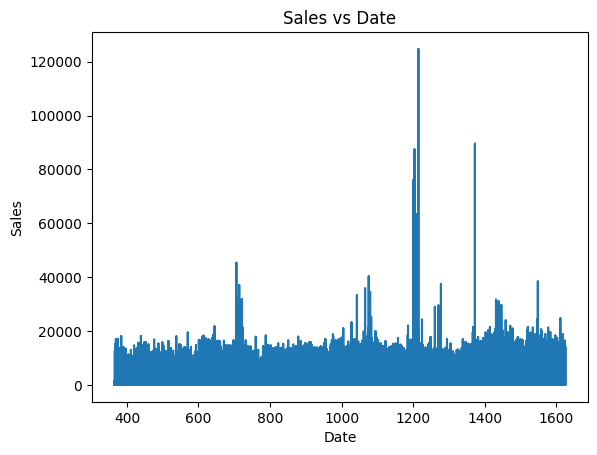

In [80]:
import matplotlib.pyplot as plt

# Filter the data for rows where is_holiday is True
holiday_data = df[df['is_holiday']]

# Plot the sales vs date
plt.plot(df['date'], df['sales'])

# Plot red line for holiday dates
plt.plot(holiday_data['date'], holiday_data['sales'], color='red')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales vs Date')

# Display the plot
plt.show()

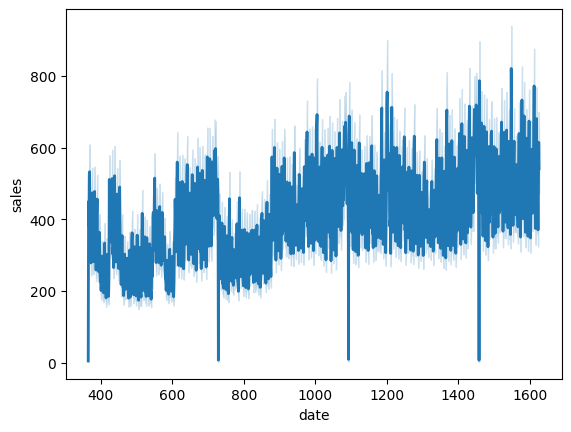

In [77]:
# Filter the data for holiday dates
holiday_data = train_with_stores_holidays[train_with_stores_holidays['is_holiday']]

# Plot the sales data
ax = sns.lineplot(x='date', y='sales', data=train_with_stores_holidays, linewidth=2)

# Plot lines for holiday dates
sns.lineplot(x='date', y='sales', data=holiday_data, color='red', linewidth=2)

plt.show()

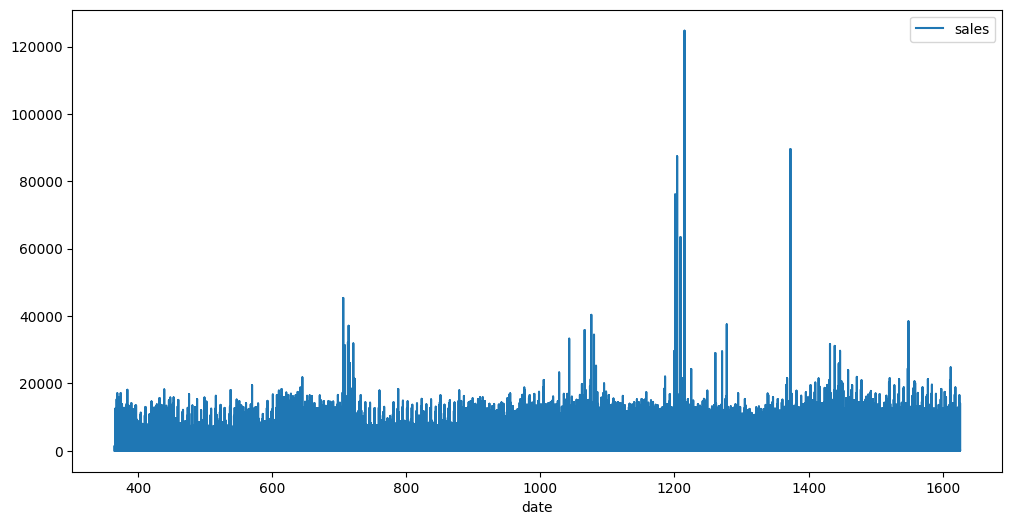

In [76]:
ax = train_with_stores_holidays.plot(x='date', y='sales', figsize=(12,6))

In [71]:
# .plot(x='date', y='transaction', figsize=(12,6))
def plot_over_time(df, column):

  ax = df.set_index('date').plot(x=df.index, y=column, figsize=(12,6))
  ax.title = 'Sales over time'
  return ax

In [74]:
plot_over_time(train, 'sales')

KeyError: ignored

In [67]:
df = train_with_stores_holidays
df['dayofyear'] = df['date'].dt.dayofyear
df["sin(dayofyear)"] = np.sin(df["dayofyear"])
df["cos(dayofyear)"] = np.cos(df["dayofyear"])

AttributeError: ignored

In [ ]:
xcoords = ['1970-01-01', '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01',
          '2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

## Answering Questions

1. Is the train data complete?

Yes. The output below shows that our train data is complete.

In [ ]:
get_missing_dates(train)

2. Do we have seasonality in our transactions?

3. Are there outliers in our dataset?

4. What is the difference between RMSLE, RMSE and MSE?

## Univariate Analysis

## Bivariate Analysis

## Multivariate Analysis

# Feature Engineering

## Creating New Features

In [ ]:
dates.columns

In [ ]:
def getDateFeatures(df):
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.isocalendar().week

    df['quarter'] = df['date'].dt.quarter
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df['date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)

    # Extract the 'year' and 'weekofyear' components from the 'date' column
    df['year_weekofyear'] = df['date'].dt.year * 100 + df['date'].dt.weekofyear
    # create new coolumns to represent the cyclic nature of a year
    df['dayofyear'] = df['date'].dt.dayofyear
    df["sin(dayofyear)"] = np.sin(df["dayofyear"])
    df["cos(dayofyear)"] = np.cos(df["dayofyear"])

    df['week_of_year'] = df['week_of_year'].astype(float)
    df["is_weekend"] = np.where(df['day_of_week'] > 4, 1, 0)

    # Define the criteria for each season
    seasons = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Autumn': [9, 10, 11]}

    # Create the 'season' column based on the 'date' column
    df['season'] = df['date'].dt.month.map({month: season for season, months in seasons.items() for month in months})

    return df

In [ ]:
getDateFeatures(train)

In [ ]:
getDateFeatures(test)

In [ ]:
train.columns

first, lets have a quick overview before deciding how to handle missing values

In [ ]:
merged3.isnull().sum()

since non-holidays are work days, let's impute the last column

In [ ]:
merged3['type_y'].unique()

In [ ]:
work_days = merged3[merged3['type_y'] == 'Work Day']
print(work_days.nunique())
work_days

In [ ]:
# Fill missing holiday rows with work days
imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='Work Day')
merged3['type_y'] = imputer.fit_transform(merged3[['type_y']])

In [ ]:
merged3.isna().sum()

In [ ]:
merged3.to_csv('merged_train_data.csv', index=False)

In [ ]:
merged3 = getDateFeatures(merged3)

let's make the date column the index

In [ ]:
merged3=merged3.set_index(['date'])

## Features Encoding & scaling

In [ ]:
merged3.head(2)

In [ ]:
merged3.oil_price.unique()

In [ ]:
categoric_columns = ['family', 'city', 'state', 'type_y', 'type_x']
columns = list(merged3.columns) 
numeric_columns = [i for i in columns if i not in categoric_columns]

In [ ]:
numeric_columns.remove('sales')
print(numeric_columns)

In [ ]:
encoder = BinaryEncoder(drop_invariant=False, return_df=True,)
encoder.fit(merged3[categoric_columns])

In [ ]:
scaler = StandardScaler()
scaler.set_output(transform="pandas")
scaler.fit(merged3[numeric_columns])

In [ ]:
import pickle

with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
scaled_num = scaler.transform(merged3[numeric_columns])
encoded_cat = encoder.transform(merged3[categoric_columns])
merged3 = pd.concat([scaled_num, encoded_cat, merged3.sales], axis=1)

## Resampling

In [ ]:
train_daily_mean = (
    train__with_all_dates
    .set_index('date')
    .resample('D').mean()
)
print(train_daily_mean.shape)
train_daily_mean.head(3)

In [ ]:
# sales_data = train_daily_mean.drop(columns=['store_nbr', 'onpromotion'])
sales_data = train_daily_mean['sales']
sales_data = sales_data.fillna(0)

In [ ]:
train1=train_daily_mean

In [ ]:
trainn, evall = merged3[30000:], merged3[:30000]

In [ ]:
# Split data into parts
x = trainn.drop(['sales'], axis = 1)
y = trainn['sales']

In [ ]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[200:], x[:200], y[200:], y[:200]

# Machine Learning Modeling 

# Traditional Machine Learning Models

### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
model_tree = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_tree.predict(X_test)

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(model_tree, f)

In [ ]:
# feature importance for decision tree
plt.figure(figsize=(12,7))
plt.barh(x.columns, model_tree.feature_importances_)

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(tree_pred, label='DecisionTreeRegressor')
plt.legend(loc='best')
plt.title('DecisionTreeRegressor Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, tree_pred )
rmse = np.sqrt(mean_squared_error(y_test, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)
msle = mean_squared_log_error(y_test, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = results.append(model_results, ignore_index = True)
results

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, neigh_pred )
msle = mean_squared_log_error(y_test, neigh_pred)
rmse = np.sqrt(mean_squared_error(y_test, neigh_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
model_results = pd.DataFrame([['KNN', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

# Models Comparison

# Model Evaluation (Backtests)

In [ ]:
backtests = {
    1: ('2017-07-01', '2017-07-15'),
    2: ('2017-07-15', '2017-07-30'),
    3: ('2017-08-01', '2017-08-15')
}

In [ ]:
# Backtests with Decision Tree
scores = {}

for idx, period in enumerate(backtests):
    
    _train = trainn.reset_index()[trainn.reset_index()['date'] < backtests[period][0]]
    _test = trainn.reset_index()[(trainn.reset_index()['date'] >= backtests[period][0]) & (trainn.reset_index()['date'] <= backtests[period][1])]
    
    Xtrain, ytrain = _train.set_index(['date']).drop(columns=['sales']).values, _train.sales.values
    Xtest, ytest = _test.set_index(['date']).drop(columns=['sales']).values, _test.sales.values
    
    lgbm_model = DecisionTreeRegressor().fit(Xtrain, ytrain)
    
    ypred = lgbm_model.predict(Xtest)
    
    scores[period] = np.sqrt(mean_squared_log_error(ytest, ypred))

print(scores)

In [ ]:
# Split data into parts
x = evall.drop(['sales'], axis = 1)
y = evall['sales']

In [ ]:
# Make prediction on X_test
tree_pred = neigh.predict(x)

In [ ]:
mse = mean_squared_error(y, tree_pred )
rmse = np.sqrt(mean_squared_error(y, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y, tree_pred)).round(6)
msle = mean_squared_log_error(y, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

In [ ]:
test

for our test data, we merge just like for our train data

In [ ]:
mer_test = test.merge(
    stores, 
    how='left', 
    on=['store_nbr'])
#merging merged with oil data
merged2_test=mer_test.merge(
    oil,
    how='left', 
    on=['date'])
#merging merged2 with holidays
merged3_test=merged2_test.merge(holidays,
    how='left', 
    on=['date'])

In [ ]:
merged3.isnull().sum()

### predicting sales in our test

In [ ]:
# test_pred = armodel.predict(merged3_test_resampled)
test_pred = armodel.predict(
    start=len(x),
    end=len(x)+ len(test_date) -1,
    dynamic=False
)
test_pred[np.isnan(test_pred)] = 0
test_pred

In [ ]:
test_sales = pd.DataFrame(test_pred, columns=['sales'])
test_sales.head(30)

In [ ]:
# Save sample submission
# test_sales[[ 'sales']].to_csv('submission.csv', index=False)